<a href="https://colab.research.google.com/github/shehzadaamir/4th_order_ode/blob/main/Idrees_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Example 1

Epoch 0, Loss: 4.693165302276611
Epoch 1000, Loss: 4.76495515613351e-05
Epoch 2000, Loss: 2.174750823868976e-09
Epoch 3000, Loss: 2.500046177023041e-12
Epoch 4000, Loss: 2.3889410415145473e-12
x		Exact		PINN Error		OHAM Error
0.0		0.000000	0.000000000000000e+00		2.096100000000000e-13
0.1		0.099833	0.000000000000000e+00		3.440910000000000e-08
0.2		0.198669	0.000000000000000e+00		1.138450000000000e-07
0.3		0.295520	0.000000000000000e+00		2.066890000000000e-07
0.4		0.389418	0.000000000000000e+00		2.826620000000000e-07
0.5		0.479426	0.000000000000000e+00		3.151730000000000e-07
0.6		0.564642	0.000000000000000e+00		2.900290000000000e-07
0.7		0.644218	0.000000000000000e+00		2.141580000000000e-07
0.8		0.717356	0.000000000000000e+00		1.161360000000000e-07
0.9		0.783327	0.000000000000000e+00		3.405550000000000e-08
1.0		0.841471	0.000000000000000e+00		1.441070000000000e-13


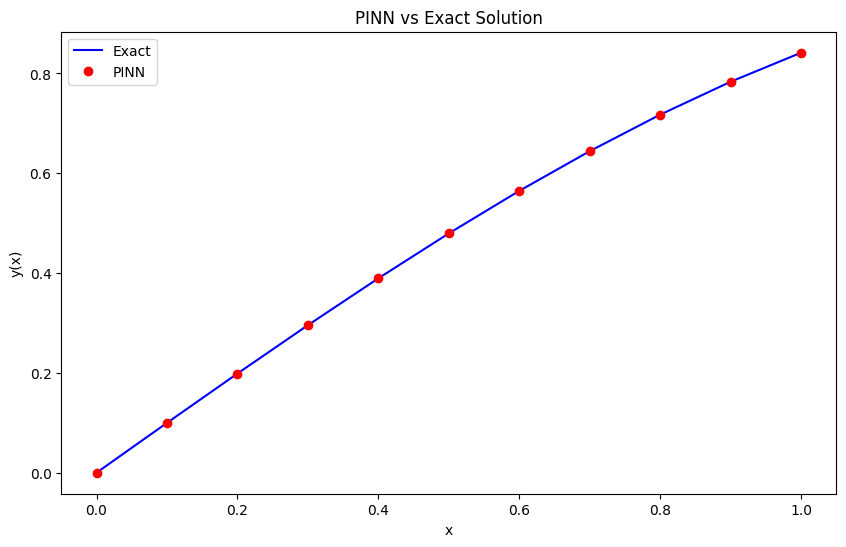

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

x_train = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

def g(x):
    return -torch.sin(x) - (torch.sin(x))**2

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    NN_output = model(x_train)
    T = (x_train**2) * ((1 - x_train)**2) * NN_output
    y = torch.sin(x_train) + T  # Enforce hard BCs

    # Compute derivatives
    T_x = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x_train, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
    T_xxx = torch.autograd.grad(T_xx, x_train, grad_outputs=torch.ones_like(T_xx), create_graph=True)[0]
    T_iv = torch.autograd.grad(T_xxx, x_train, grad_outputs=torch.ones_like(T_xxx), create_graph=True)[0]

    # Compute residual
    y_iv = torch.sin(x_train) + T_iv
    y_xx = -torch.sin(x_train) + T_xx
    residual = y_iv + g(x_train) + (y_xx)**2

    # Loss
    loss = torch.mean(residual**2)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

x_test = torch.linspace(0, 1, 11).view(-1, 1)
y_pred = torch.sin(x_test) + (x_test**2) * ((1 - x_test)**2) * model(x_test)
y_exact = torch.sin(x_test)
error_pinn = torch.abs(y_pred - y_exact).detach().numpy().flatten()

# OHAM results from Table 1
oham = np.array([
    2.0961e-13, 3.44091e-8, 1.13845e-7, 2.06689e-7, 2.82662e-7,
    3.15173e-7, 2.90029e-7, 2.14158e-7, 1.16136e-7, 3.40555e-8, 1.44107e-13
])

# Print comparison table
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(11):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{y_exact[i].item():.6f}\t{error_pinn[i]:.15e}\t\t{oham[i]:.15e}")


plt.figure(figsize=(10, 6))
plt.plot(x_test.detach().numpy(), y_exact.detach().numpy(), 'b-', label='Exact')
plt.plot(x_test.detach().numpy(), y_pred.detach().numpy(), 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution')
plt.show()

##Example 2

Epoch 0, Loss: 1801.4052734375
Epoch 1000, Loss: 0.02898379974067211
Epoch 2000, Loss: 0.007984261959791183
Epoch 3000, Loss: 0.004447875078767538
Epoch 4000, Loss: 0.0020090234465897083
Epoch 5000, Loss: 0.0006031112279742956

Comparison Table
x		Exact		PINN Error		OHAM Error
0.0		0.00000	0.0000000000e+00	0.0000000000e+00
0.1		0.01981	7.6368451118e-08	7.2790800000e-08
0.2		0.07712	9.2387199402e-07	2.4521600000e-07
0.3		0.16623	2.0563602448e-06	4.4886800000e-07
0.4		0.27904	1.9967556000e-06	6.1861500000e-07
0.5		0.40625	2.9802322388e-07	6.9995100000e-07
0.6		0.53856	1.7285346985e-06	6.6128000000e-07
0.7		0.66787	2.3245811462e-06	5.0744600000e-07
0.8		0.78848	1.1920928955e-06	2.8710400000e-07
0.9		0.89829	1.1920928955e-07	8.5665600000e-08
1.0		1.00000	0.0000000000e+00	0.0000000000e+00


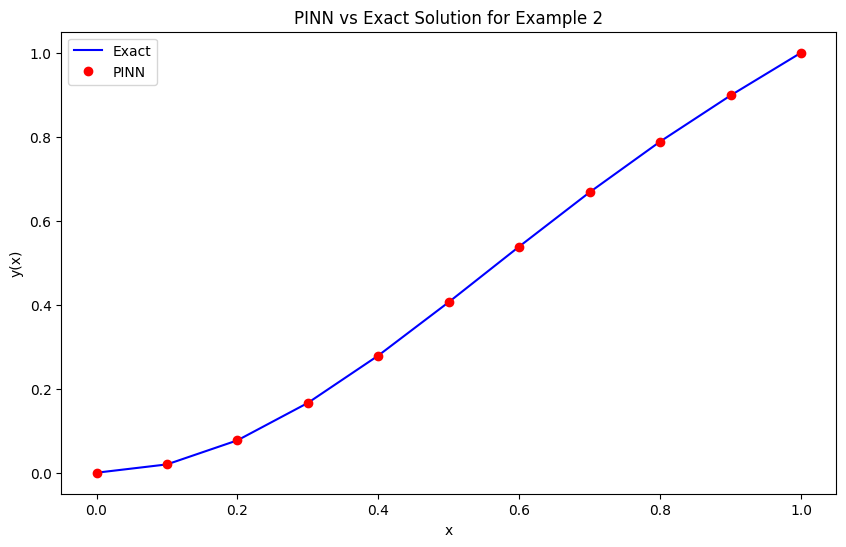

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 1)
        self.activation = nn.Tanh()  # Changed to Tanh for better performance

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define baseline function A(x) = -x³ + 2x² to satisfy BCs
def A(x):
    return -x**3 + 2*x**2

# Define the polynomial term in the ODE
def f_poly(x):
    return (x**10 - 4*x**9 + 4*x**8 + 4*x**7
            - 8*x**6 + 4*x**4 - 120*x + 48)

# Training points
x_train = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 5001
for epoch in range(epochs):
    optimizer.zero_grad()

    # Network output and solution construction
    NN_output = model(x_train)
    y = A(x_train) + (x_train**2 * (1 - x_train)**2) * NN_output

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y),
                             create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x),
                              create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx),
                               create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx),
                              create_graph=True)[0]

    # Compute residual
    residual = y_iv - y**2 + f_poly(x_train)

    # Loss calculation
    loss = torch.mean(residual**2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
x_test = torch.linspace(0, 1, 11).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = A(x_test) + (x_test**2 * (1 - x_test)**2) * NN_pred

# Exact solution from table
y_exact = torch.tensor([
    [0.0], [0.01981], [0.07712], [0.16623], [0.27904],
    [0.40625], [0.53856], [0.66787], [0.78848], [0.89829], [1.0]
], dtype=torch.float32)

# Error calculation
error_pinn = torch.abs(y_pred - y_exact).numpy().flatten()

# OHAM results from table
oham_error = np.array([
    0.0, 7.27908e-8, 2.45216e-7, 4.48868e-7, 6.18615e-7,
    6.99951e-7, 6.6128e-7, 5.07446e-7, 2.87104e-7, 8.56656e-8, 0.0
])

# Print comparison table
print("\nComparison Table")
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(11):
    x_val = x_test[i].item()
    exact_val = y_exact[i].item()
    print(f"{x_val:.1f}\t\t{exact_val:.5f}\t{error_pinn[i]:.10e}\t{oham_error[i]:.10e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), y_exact.numpy(), 'b-', label='Exact')
plt.plot(x_test.numpy(), y_pred.numpy(), 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution for Example 2')
plt.show()

### Example 2 with 9000 epochs

Epoch 0, Loss: 1228.44189453125
Epoch 100, Loss: 8.491565704345703
Epoch 200, Loss: 2.4199249744415283
Epoch 300, Loss: 0.5561364889144897
Epoch 400, Loss: 0.18419155478477478
Epoch 500, Loss: 0.13031764328479767
Epoch 600, Loss: 0.10839003324508667
Epoch 700, Loss: 0.09028496593236923
Epoch 800, Loss: 0.07465565204620361
Epoch 900, Loss: 0.06132115051150322
Epoch 1000, Loss: 0.0500812903046608
Epoch 1100, Loss: 0.04071515053510666
Epoch 1200, Loss: 0.03299933299422264
Epoch 1300, Loss: 0.02671828307211399
Epoch 1400, Loss: 0.02166679874062538
Epoch 1500, Loss: 0.017654744908213615
Epoch 1600, Loss: 0.014508791267871857
Epoch 1700, Loss: 0.012072875164449215
Epoch 1800, Loss: 0.010208535008132458
Epoch 1900, Loss: 0.00879612471908331
Epoch 2000, Loss: 0.007733176462352276
Epoch 2100, Loss: 0.006934662349522114
Epoch 2200, Loss: 0.006331678479909897
Epoch 2300, Loss: 0.005868840962648392
Epoch 2400, Loss: 0.005504325032234192
Epoch 2500, Loss: 0.00520673580467701
Epoch 2600, Loss: 0.004

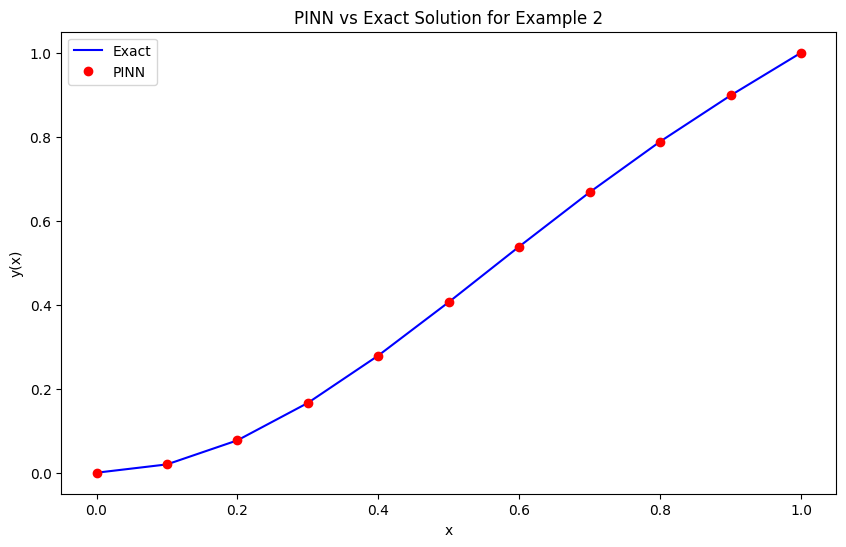

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 1)
        self.activation = nn.Tanh()  # Changed to Tanh for better performance

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define baseline function A(x) = -x³ + 2x² to satisfy BCs
def A(x):
    return -x**3 + 2*x**2

# Define the polynomial term in the ODE
def f_poly(x):
    return (x**10 - 4*x**9 + 4*x**8 + 4*x**7
            - 8*x**6 + 4*x**4 - 120*x + 48)

# Training points
x_train = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 8001
for epoch in range(epochs):
    optimizer.zero_grad()

    # Network output and solution construction
    NN_output = model(x_train)
    y = A(x_train) + (x_train**2 * (1 - x_train)**2) * NN_output

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y),
                             create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x),
                              create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx),
                               create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx),
                              create_graph=True)[0]

    # Compute residual
    residual = y_iv - y**2 + f_poly(x_train)

    # Loss calculation
    loss = torch.mean(residual**2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
x_test = torch.linspace(0, 1, 11).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = A(x_test) + (x_test**2 * (1 - x_test)**2) * NN_pred

# Exact solution from table
y_exact = torch.tensor([
    [0.0], [0.01981], [0.07712], [0.16623], [0.27904],
    [0.40625], [0.53856], [0.66787], [0.78848], [0.89829], [1.0]
], dtype=torch.float32)

# Error calculation
error_pinn = torch.abs(y_pred - y_exact).numpy().flatten()

# OHAM results from table
oham_error = np.array([
    0.0, 7.27908e-8, 2.45216e-7, 4.48868e-7, 6.18615e-7,
    6.99951e-7, 6.6128e-7, 5.07446e-7, 2.87104e-7, 8.56656e-8, 0.0
])

# Print comparison table
print("\nComparison Table")
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(11):
    x_val = x_test[i].item()
    exact_val = y_exact[i].item()
    print(f"{x_val:.1f}\t\t{exact_val:.5f}\t{error_pinn[i]:.10e}\t{oham_error[i]:.10e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), y_exact.numpy(), 'b-', label='Exact')
plt.plot(x_test.numpy(), y_pred.numpy(), 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution for Example 2')
plt.show()

##Example 5

Epoch 0, Loss: 25.51540756225586
Epoch 1000, Loss: 0.003929005470126867
Epoch 2000, Loss: 0.00011704502685461193
Epoch 3000, Loss: 1.3026285614614608e-06
Epoch 4000, Loss: 9.630996800069624e-08
Epoch 5000, Loss: 6.79263578717837e-08
Epoch 6000, Loss: 6.702536836655781e-08
Epoch 7000, Loss: 6.702957477955351e-08
Epoch 8000, Loss: 6.642144256829852e-08
Epoch 9000, Loss: 6.645163352914096e-08

Comparison Table
x		PINN Prediction		VIM Error		OHAM Error
0.0		0.00000000		0.0000e+00		0.0000e+00
0.1		0.00150578		1.2225e-07		8.3578e-06
0.2		0.00540594		4.4546e-07		3.1605e-05
0.3		0.01084977		9.7202e-07		6.6928e-05
0.4		0.01708659		1.7860e-06		1.1141e-04
0.5		0.02346567		2.6669e-06		1.6243e-04
0.6		0.02943467		2.1698e-06		2.1883e-04
0.7		0.03454379		8.8992e-07		2.7681e-04
0.8		0.03844294		6.6048e-07		3.3326e-04
0.9		0.04088193		2.1719e-06		3.8497e-04
1.0		0.04171073		3.6656e-06		4.2867e-04
1.1		0.04087946		4.6381e-06		4.6104e-04
1.2		0.03843829		5.3096e-06		4.7871e-04
1.3		0.03453751		5.3872e-06

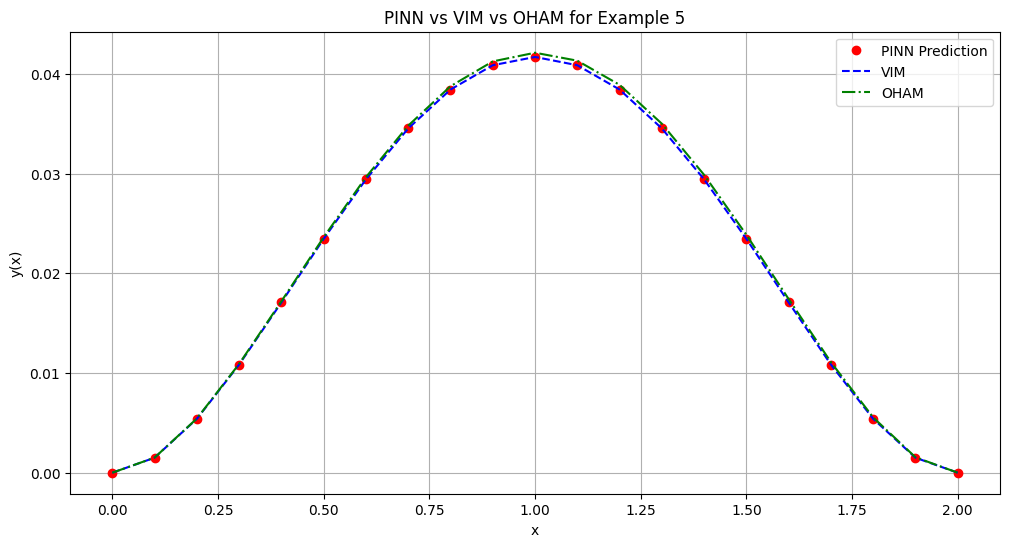

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network (similar to Example 1)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define solution structure to enforce BCs: y(x) = x²(2-x)² * NN(x)
def solution(x, nn_output):
    return (x**2) * ((2 - x)**2) * nn_output

# Training data
x_train = torch.linspace(0, 2, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    NN_output = model(x_train)
    y = solution(x_train, NN_output)

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y),
                             create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x),
                              create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx),
                               create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx),
                              create_graph=True)[0]

    # Compute residual
    residual = y_iv - y**2 - 1

    # Loss
    loss = torch.mean(residual**2)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions at specified points
x_test = torch.linspace(0, 2, 21).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = solution(x_test, NN_pred).numpy().flatten()

# Reference solutions from Table 5
vim = np.array([
    0.0, 0.00150566, 0.00540549, 0.0108488, 0.0170848, 0.023463,
    0.0294325, 0.0345429, 0.0384436, 0.0408841, 0.0417144, 0.0408841,
    0.0384436, 0.0345429, 0.0294325, 0.023463, 0.0170848, 0.0108488,
    0.00540549, 0.00150566, -8.56316E-19
])

oham = np.array([
    0.0, 0.00151414, 0.00543754, 0.0109167, 0.017198, 0.0236281,
    0.0296535, 0.0348206, 0.0387762, 0.0412669, 0.0421394, 0.0413405,
    0.038917, 0.0350157, 0.0298836, 0.0238686, 0.0174205, 0.0110928,
    0.00554551, 0.00155084, 4.85017E-13
])

# Calculate errors
error_vim = np.abs(y_pred - vim)
error_oham = np.abs(y_pred - oham)

# Print comparison table
print("\nComparison Table")
print("x\t\tPINN Prediction\t\tVIM Error\t\tOHAM Error")
for i in range(21):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{y_pred[i]:.8f}\t\t{error_vim[i]:.4e}\t\t{error_oham[i]:.4e}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x_test.numpy(), y_pred, 'ro', label='PINN Prediction')
plt.plot(x_test.numpy(), vim, 'b--', label='VIM')
plt.plot(x_test.numpy(), oham, 'g-.', label='OHAM')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs VIM vs OHAM for Example 5')
plt.grid(True)
plt.show()

Epoch 0, Loss: 5.093906402587891
Epoch 1000, Loss: 7.56264944357099e-06
Epoch 2000, Loss: 5.143999359802365e-08
Epoch 3000, Loss: 2.00972127828436e-08
Epoch 4000, Loss: 1.997912235651711e-08
Epoch 5000, Loss: 2.0040452852754242e-08

Comparison Table
x		PINN Prediction		VIM Error		OHAM Error
0.0		0.00000000		0.0000e+00		0.0000e+00
0.1		0.00150618		5.2306e-07		7.9569e-06
0.2		0.00540744		1.9505e-06		3.0100e-05
0.3		0.01085293		4.1329e-06		6.3767e-05
0.4		0.01709272		7.9178e-06		1.0528e-04
0.5		0.02347445		1.1451e-05		1.5365e-04
0.6		0.02944781		1.5313e-05		2.0569e-04
0.7		0.03456182		1.8924e-05		2.5878e-04
0.8		0.03846563		2.2027e-05		3.1057e-04
0.9		0.04090624		2.2139e-05		3.6066e-04
1.0		0.04173519		2.0795e-05		4.0421e-04
1.1		0.04090309		1.8991e-05		4.3741e-04
1.2		0.03846021		1.6614e-05		4.5679e-04
1.3		0.03455694		1.4044e-05		4.5876e-04
1.4		0.02944383		1.1328e-05		4.3977e-04
1.5		0.02347154		8.5417e-06		3.9706e-04
1.6		0.01709080		6.0011e-06		3.2970e-04
1.7		0.01085241		3.6058e-06	

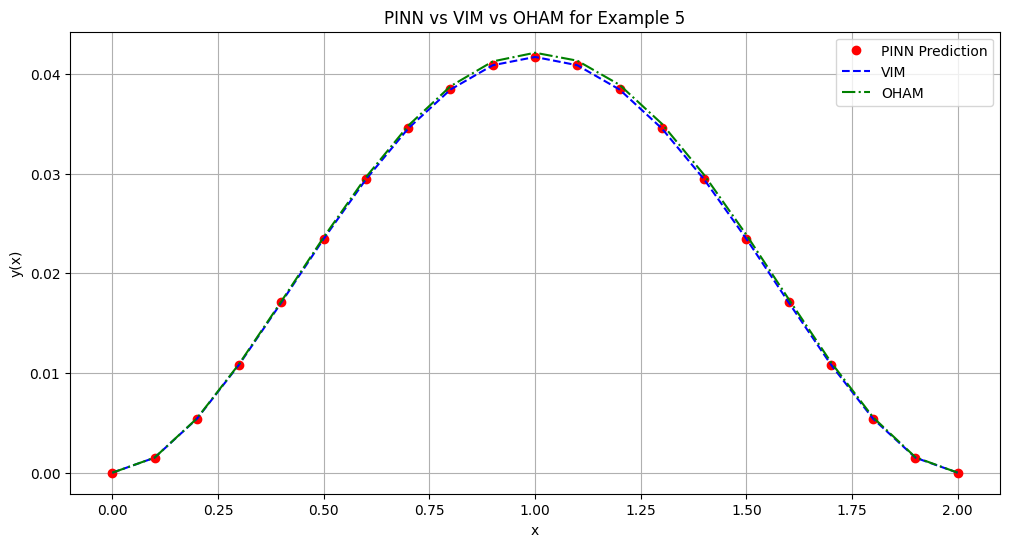

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network (similar to Example 1)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define solution structure to enforce BCs: y(x) = x²(2-x)² * NN(x)
def solution(x, nn_output):
    return (x**2) * ((2 - x)**2) * nn_output

# Training data
x_train = torch.linspace(0, 2, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 5001
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    NN_output = model(x_train)
    y = solution(x_train, NN_output)

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y),
                             create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x),
                              create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx),
                               create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx),
                              create_graph=True)[0]

    # Compute residual
    residual = y_iv - y**2 - 1

    # Loss
    loss = torch.mean(residual**2)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions at specified points
x_test = torch.linspace(0, 2, 21).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = solution(x_test, NN_pred).numpy().flatten()

# Reference solutions from Table 5
vim = np.array([
    0.0, 0.00150566, 0.00540549, 0.0108488, 0.0170848, 0.023463,
    0.0294325, 0.0345429, 0.0384436, 0.0408841, 0.0417144, 0.0408841,
    0.0384436, 0.0345429, 0.0294325, 0.023463, 0.0170848, 0.0108488,
    0.00540549, 0.00150566, -8.56316E-19
])

oham = np.array([
    0.0, 0.00151414, 0.00543754, 0.0109167, 0.017198, 0.0236281,
    0.0296535, 0.0348206, 0.0387762, 0.0412669, 0.0421394, 0.0413405,
    0.038917, 0.0350157, 0.0298836, 0.0238686, 0.0174205, 0.0110928,
    0.00554551, 0.00155084, 4.85017E-13
])

# Calculate errors
error_vim = np.abs(y_pred - vim)
error_oham = np.abs(y_pred - oham)

# Print comparison table
print("\nComparison Table")
print("x\t\tPINN Prediction\t\tVIM Error\t\tOHAM Error")
for i in range(21):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{y_pred[i]:.8f}\t\t{error_vim[i]:.4e}\t\t{error_oham[i]:.4e}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x_test.numpy(), y_pred, 'ro', label='PINN Prediction')
plt.plot(x_test.numpy(), vim, 'b--', label='VIM')
plt.plot(x_test.numpy(), oham, 'g-.', label='OHAM')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs VIM vs OHAM for Example 5')
plt.grid(True)
plt.show()

## Example 3

Epoch 0, Loss: 3.040475845336914
Epoch 1000, Loss: 2.8368690436764155e-06
Epoch 2000, Loss: 0.0029748110100626945
Epoch 3000, Loss: 7.839311706447916e-07
Epoch 4000, Loss: 2.746456004842912e-07

Comparison Table
x		Exact		PINN Error		OHAM Error
-1.0		0.000000	0.000000000000000e+00	0.000000000000000e+00
-0.9		0.020195	1.884703106005639e-02	1.884703106005639e-02
-0.8		0.039769	3.494000269212127e-02	3.494000269212127e-02
-0.7		0.058184	4.851281378890276e-02	4.851281378890276e-02
-0.6		0.074985	5.978577553540468e-02	5.978577553540468e-02
-0.5		0.089796	6.895969768638611e-02	6.895969768638611e-02
-0.4		0.102311	7.621216006135940e-02	7.621216006135940e-02
-0.3		0.112286	8.169202362155914e-02	8.169202362155914e-02
-0.2		0.119538	8.551869742321969e-02	8.551869742321969e-02
-0.1		0.123940	8.777999288082122e-02	8.777999288082122e-02
-0.0		0.125416	8.852823506927490e-02	8.852823506927490e-02
0.1		0.123940	8.778006366133689e-02	8.778006366133689e-02
0.2		0.119538	8.551877937960625e-02	8.5518779379

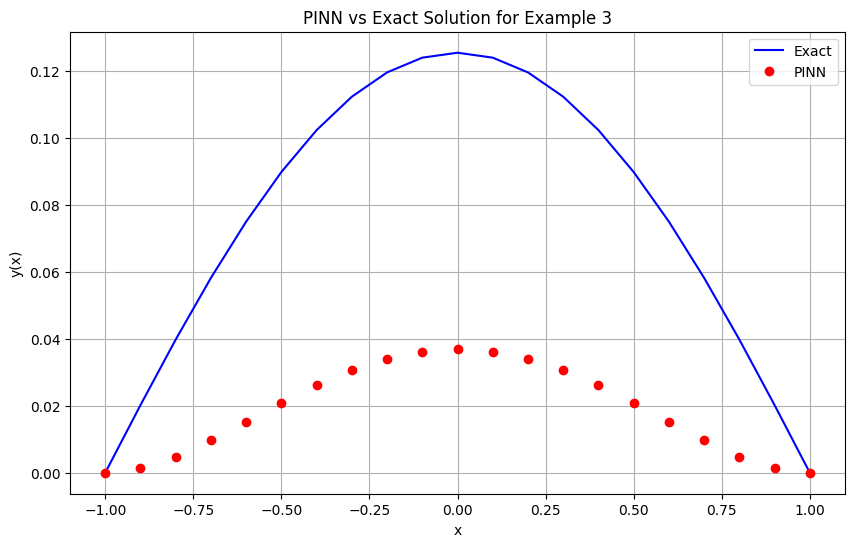

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network (same architecture as Example 1)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 40)
        self.fc6 = nn.Linear(40, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.fc6(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define solution structure to enforce BCs: y(x) = (x^2 - 1)^2 * NN(x)
def solution(x, nn_output):
    return (x**2 - 1)**2 * nn_output

# Training data on [-1, 1]
x_train = torch.linspace(-1, 1, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    NN_output = model(x_train)
    y = solution(x_train, NN_output)

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y),
                             create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x),
                              create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx),
                               create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx),
                              create_graph=True)[0]

    # Compute residual: y_iv - (1 - 4y)
    residual = y_iv - (1 - 4*y)

    # Loss
    loss = torch.mean(residual**2)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions at Table 3 points
x_test = torch.linspace(-1, 1, 21).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = solution(x_test, NN_pred).numpy().flatten()

# Exact solution from Table 3
exact = np.array([
    0.0, 0.0201954, 0.0397693, 0.0581837, 0.074985, 0.0897962,
    0.102311, 0.112286, 0.119538, 0.12394, 0.125416, 0.12394,
    0.119538, 0.112286, 0.102311, 0.0897962, 0.074985, 0.0581837,
    0.0397693, 0.0201954, 0.0
])

# OHAM results from Table 3
oham = np.array([
    0.0, 0.0201954, 0.0397693, 0.0581837, 0.074985, 0.0897962,
    0.102311, 0.112286, 0.119538, 0.12394, 0.125416, 0.12394,
    0.119538, 0.112286, 0.102311, 0.0897962, 0.074985, 0.0581837,
    0.0397693, 0.0201954, 3.96466E-17
])

# Compute errors
error_exact = np.abs(y_pred - exact)
error_oham = np.abs(y_pred - oham)

# Print comparison table
print("\nComparison Table")
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(21):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{exact[i]:.6f}\t{error_exact[i]:.15e}\t{error_oham[i]:.15e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), exact, 'b-', label='Exact')
plt.plot(x_test.numpy(), y_pred, 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution for Example 3')
plt.grid(True)
plt.show()

Epoch 0, Loss: 947.16015625, LR: 0.001
Epoch 1000, Loss: 0.8418318033218384, LR: 0.001
Epoch 2000, Loss: 0.8401910662651062, LR: 0.001
Epoch 3000, Loss: 0.8393690586090088, LR: 0.001
Epoch 4000, Loss: 0.8388519883155823, LR: 0.0005
Epoch 5000, Loss: 0.8387691974639893, LR: 3.125e-05
Epoch 6000, Loss: 0.8387657999992371, LR: 9.765625e-07
Epoch 7000, Loss: 0.8387656211853027, LR: 3.0517578125e-08
Epoch 8000, Loss: 0.8387655019760132, LR: 1.52587890625e-08
Epoch 9000, Loss: 0.8387655019760132, LR: 1.52587890625e-08

Comparison Table
x		Exact		PINN Error		OHAM Error
-1.0		0.000000	0.000000000000000e+00	0.000000000000000e+00
-0.9		0.020195	2.021767410914202e-02	2.021767410914202e-02
-0.8		0.039769	3.991987604468893e-02	3.991987604468893e-02
-0.7		0.058184	5.861087662290670e-02	5.861087662290670e-02
-0.6		0.074985	7.582834373241290e-02	7.582834373241290e-02
-0.5		0.089796	9.115152859712840e-02	9.115152859712840e-02
-0.4		0.102311	1.042108206360266e-01	1.042108206360266e-01
-0.3		0.112286	1.1

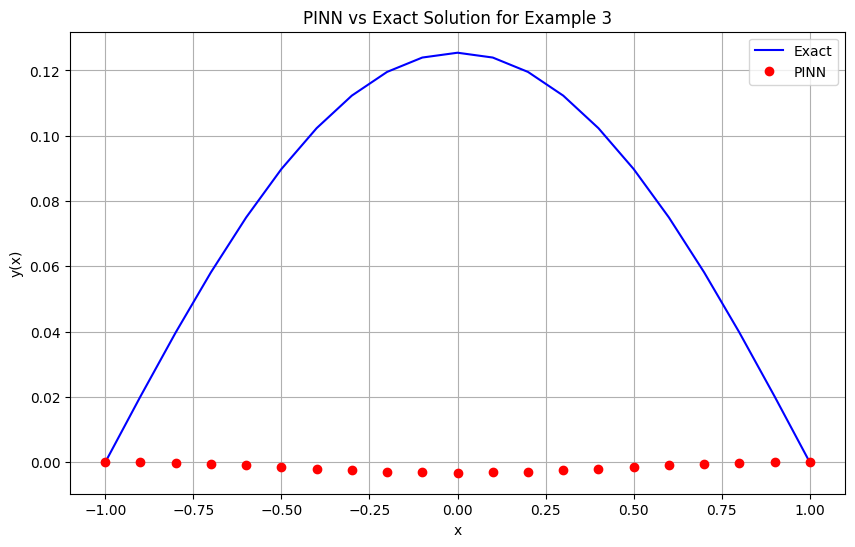

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define a deeper network with Tanh activation
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 1)
        self.activation = nn.Tanh()  # Smoother derivatives

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200)  # Adaptive LR

# Corrected solution structure to enforce y''(±1) = 0
def solution(x, nn_output):
    return (x**2 - 1)**2 * (x**2 - 1) * nn_output  # (x² - 1)^3 * NN(x)

# Training data
x_train = torch.linspace(-1, 1, 100).view(-1, 1).requires_grad_(True)

# Training loop with gradient clipping
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    NN_output = model(x_train)
    y = solution(x_train, NN_output)

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x), create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx), create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx), create_graph=True)[0]

    residual = y_iv - (1 - 4*y)
    loss = torch.mean(residual**2)

    # Gradient clipping to prevent explosions
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    loss.backward()
    optimizer.step()
    scheduler.step(loss)  # Update learning rate

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

# Generate predictions at Table 3 points
x_test = torch.linspace(-1, 1, 21).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = solution(x_test, NN_pred).numpy().flatten()

# Exact solution from Table 3
exact = np.array([
    0.0, 0.0201954, 0.0397693, 0.0581837, 0.074985, 0.0897962,
    0.102311, 0.112286, 0.119538, 0.12394, 0.125416, 0.12394,
    0.119538, 0.112286, 0.102311, 0.0897962, 0.074985, 0.0581837,
    0.0397693, 0.0201954, 0.0
])

# OHAM results from Table 3
oham = np.array([
    0.0, 0.0201954, 0.0397693, 0.0581837, 0.074985, 0.0897962,
    0.102311, 0.112286, 0.119538, 0.12394, 0.125416, 0.12394,
    0.119538, 0.112286, 0.102311, 0.0897962, 0.074985, 0.0581837,
    0.0397693, 0.0201954, 3.96466E-17
])

# Compute errors
error_exact = np.abs(y_pred - exact)
error_oham = np.abs(y_pred - oham)

# Print comparison table
print("\nComparison Table")
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(21):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{exact[i]:.6f}\t{error_exact[i]:.15e}\t{error_oham[i]:.15e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), exact, 'b-', label='Exact')
plt.plot(x_test.numpy(), y_pred, 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution for Example 3')
plt.grid(True)
plt.show()

## Example 4

Epoch 0, Loss: 225.98651123046875
Epoch 1000, Loss: 0.010398137383162975
Epoch 2000, Loss: 0.000765543372835964
Epoch 3000, Loss: 0.0005256402655504644
Epoch 4000, Loss: 0.0005075380322523415
Epoch 5000, Loss: 0.0003422667214181274

Comparison Table
x		Exact		PINN Error		OHAM Error
0.0		2.000000	0.000000000000000e+00	0.000000000000000e+00
0.1		2.099820	4.905395508014720e-06	4.905395508014720e-06
0.2		2.198520	5.667190551950085e-06	5.667190551950085e-06
0.3		2.294760	1.657714843616986e-06	1.657714843616986e-06
0.4		2.386920	1.167373657295911e-06	1.167373657295911e-06
0.5		2.473080	3.496093750054996e-06	3.496093750054996e-06
0.6		2.550970	2.068252563436346e-06	2.068252563436346e-06
0.7		2.617880	3.443908691558306e-07	3.443908691558306e-07
0.8		2.670650	2.866363525200200e-06	2.866363525200200e-06
0.9		2.705560	9.267272949031735e-06	9.267272949031735e-06
1.0		2.718280	9.136886596650129e-06	9.136886596650129e-06
1.1		2.703750	6.093978881960282e-06	6.093978881960282e-06
1.2		2.656090	8.36578

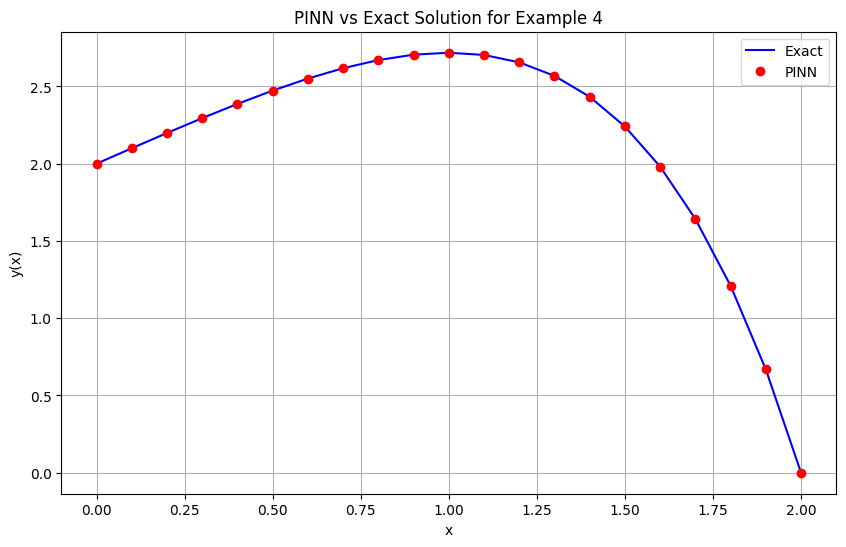

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

# Precompute coefficients for A(x)
e_sq = math.exp(2)
a = (3 - e_sq) / 4
b = (e_sq - 5) / 2

# Define baseline function A(x) to satisfy BCs
def A(x):
    return a * x**3 + b * x**2 + x + 2

# Define the neural network (same as Example 1)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training data (0 to 2)
x_train = torch.linspace(0, 2, 100).view(-1, 1).requires_grad_(True)

# Training loop
epochs = 5001
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass with BC-enforcing structure
    NN_output = model(x_train)
    y = A(x_train) + (x_train**2 * (2 - x_train)**2) * NN_output

    # Compute derivatives
    y_x = torch.autograd.grad(y, x_train, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train, grad_outputs=torch.ones_like(y_x), create_graph=True)[0]
    y_xxx = torch.autograd.grad(y_xx, x_train, grad_outputs=torch.ones_like(y_xx), create_graph=True)[0]
    y_iv = torch.autograd.grad(y_xxx, x_train, grad_outputs=torch.ones_like(y_xxx), create_graph=True)[0]

    # Compute residual
    source_term = x_train * torch.exp(x_train) - 4 * torch.exp(x_train)
    residual = y_iv - y - y_xx - source_term

    # Loss
    loss = torch.mean(residual**2)

    # Backward pass
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generate predictions at Table 4 points
x_test = torch.linspace(0, 2, 21).view(-1, 1)
with torch.no_grad():
    NN_pred = model(x_test)
    y_pred = A(x_test) + (x_test**2 * (2 - x_test)**2) * NN_pred
    y_pred = y_pred.numpy().flatten()

# Reference data from Table 4
exact = np.array([
    2.0, 2.09982, 2.19852, 2.29476, 2.38692, 2.47308,
    2.55097, 2.61788, 2.67065, 2.70556, 2.71828, 2.70375,
    2.65609, 2.56851, 2.43312, 2.24084, 1.98121, 1.64218,
    1.20993, 0.668589, 0.0
])

oham = np.array([
    2.0, 2.09982, 2.19852, 2.29476, 2.38692, 2.47308,
    2.55097, 2.61788, 2.67065, 2.70556, 2.71828, 2.70375,
    2.65609, 2.56851, 2.43312, 2.24084, 1.98121, 1.64218,
    1.20993, 0.668589, 1.23214E-15
])

# Calculate errors
error_exact = np.abs(y_pred - exact)
error_oham = np.abs(y_pred - oham)

# Print comparison table
print("\nComparison Table")
print("x\t\tExact\t\tPINN Error\t\tOHAM Error")
for i in range(21):
    x_val = x_test[i].item()
    print(f"{x_val:.1f}\t\t{exact[i]:.6f}\t{error_exact[i]:.15e}\t{error_oham[i]:.15e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), exact, 'b-', label='Exact')
plt.plot(x_test.numpy(), y_pred, 'ro', label='PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('PINN vs Exact Solution for Example 4')
plt.grid(True)
plt.show()

## eighth order ode